In [1]:

import os
import random
from datetime import datetime
import torch
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from data.datasets import AMIGOS, series_collate
from architecture.MainNetwork import MainNetwork
from utils import *


loader_kwargs = {'num_workers': 4, 'pin_memory': True, 'shuffle': True, 'drop_last': True}
root_path = 'data/face_segments'
labels_path = 'data/Data_Preprocessed_segmented.json'
vids_dir = 'data/vids_segments'
remove_mov = 'data/ignore_mov.json'
num_class = 4096
batch_size = 4
learning_rate = 1e-05
epochs = 30
alpha = 1
beta = 1
scale_factor = 1
gamma = 1
downsample = 8
normalize_val = {
    'AR': {'min': -0.42818420244970845, 'range': 0.40530026133943436 - -0.42818420244970845},
    'ECG': {'min': -2281.0594032292756, 'range': 2340.911172156569 - -2281.0594032292756},
}

x_transform = transforms.Compose([
    transforms.Normalize([0.4168, 0.3074, 0.2607], [0.2426, 0.1997, 0.1870])
])


y_transform = transforms.Compose([
    torch.FloatTensor
])
val_dataset = AMIGOS(
    root_path=root_path,
    labels_path=labels_path,
    vids_dir=vids_dir,
    remove_mov=remove_mov,
    x_transform=x_transform,
    y_transform=y_transform,
    downsample=downsample,
    normalize_val=normalize_val,
    # normalize=False
)

2023-08-25 04:26:55.816779: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 04:26:55.859014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 04:26:56.514086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ec22150/MSCPRJ/MSC-PRJ/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainNetwork(num_class).to(device)

model_path = '/home/ec22150/MSCPRJ/MSC-PRJ/models/new2/cccrmsea1full2/epoch_7.pth.tar'
state_dicts = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(1))
model.load_state_dict(state_dicts['model'])


output_names = ['AR', 'ECG']
idxs = [uid for uid in val_dataset.data.keys()]
idxs.sort()
train_uids = idxs[:(len(idxs) // 5) * 4]
val_idx = [idx[0] for idx in val_dataset.idxs if idx[1] not in train_uids]
val_set = data.Subset(val_dataset, val_idx)
test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    collate_fn=series_collate,
    **loader_kwargs
)

y_pred_AR = torch.Tensor().cuda()
y_true_AR = torch.Tensor().cuda()
y_pred_ECG = torch.Tensor().cuda()
y_true_ECG = torch.Tensor().cuda()
with torch.no_grad():
    for batch_idx, (inputs, labels1, labels2, _) in enumerate(test_loader):
        inputs, labels1, labels2 = inputs.cuda(), labels1.cuda(), labels2.cuda()
        outputs = model(inputs)
        labels = [labels1, labels2]

        y_pred_AR = torch.cat((y_pred_AR, outputs[0]), 0)
        y_true_AR = torch.cat((y_true_AR, labels[0]), 0)
        y_pred_ECG = torch.cat((y_pred_ECG, outputs[1].permute(0, 2, 1).reshape((batch_size * 2560, 2))), 0)
        y_true_ECG = torch.cat((y_true_ECG, labels[1].permute(0, 2, 1).reshape((batch_size * 2560, 2))), 0)
        del inputs, labels1, labels2

y_pred_ARs = y_pred_AR.permute(1, 0)
y_true_ARs = y_true_AR.permute(1, 0)
y_pred_ECGs = y_pred_ECG.permute(1, 0)
y_true_ECGs = y_true_ECG.permute(1, 0)

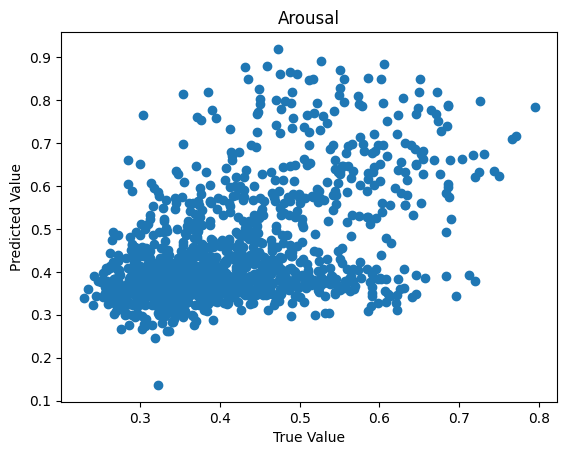

In [3]:
scatter = scatter_fn(y_pred_ARs[0].cpu(), y_true_ARs[0].cpu())
plt.title('Arousal')
scatter.savefig('Arousal.jpg')

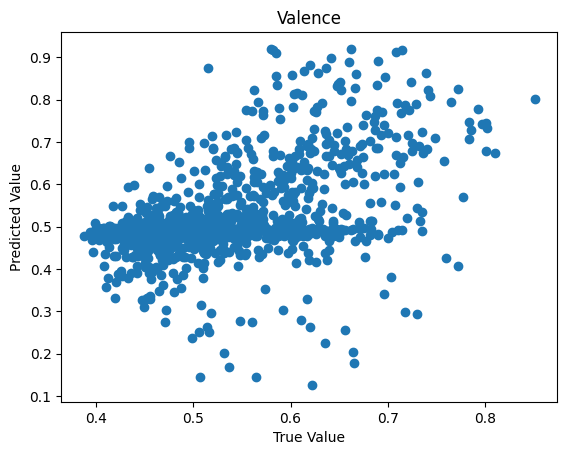

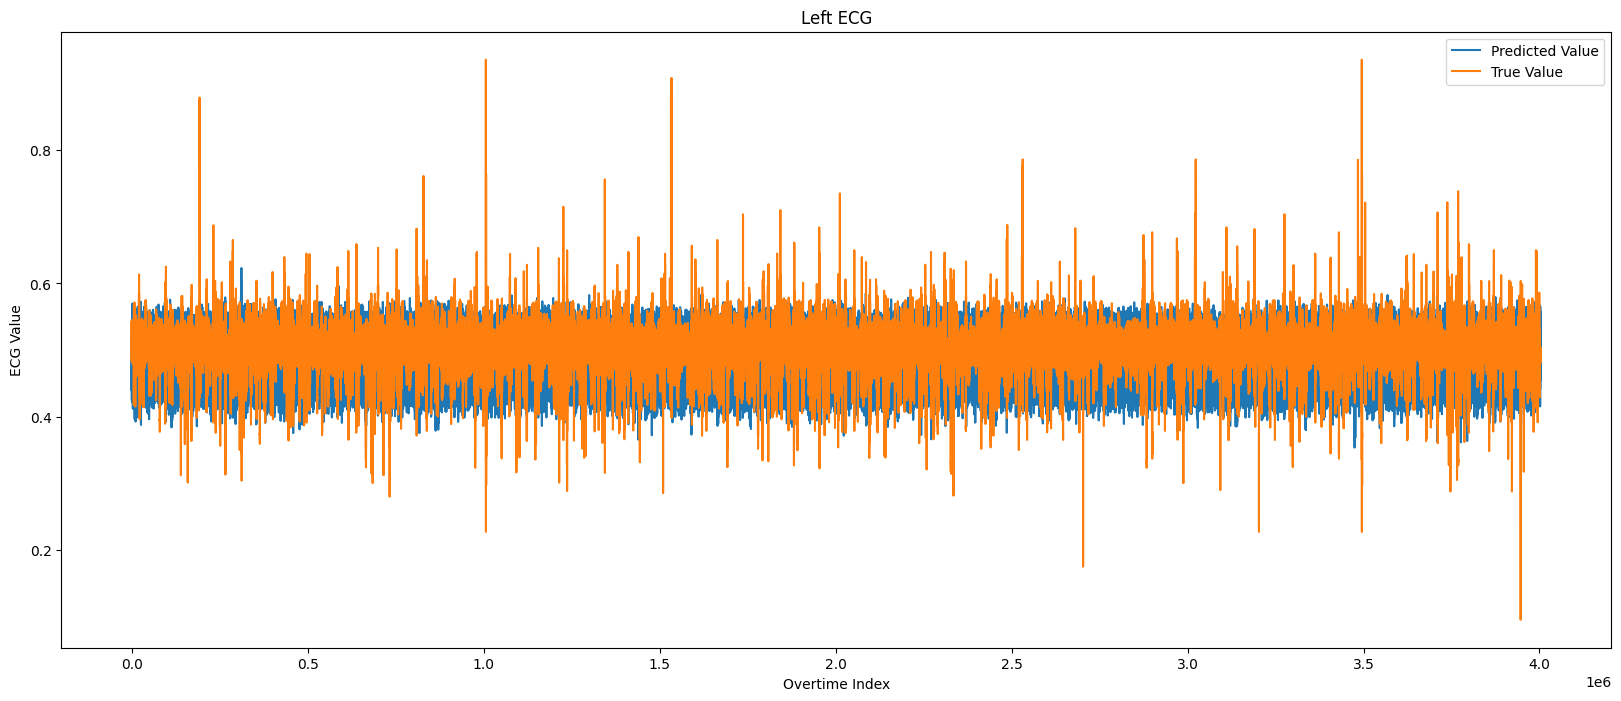

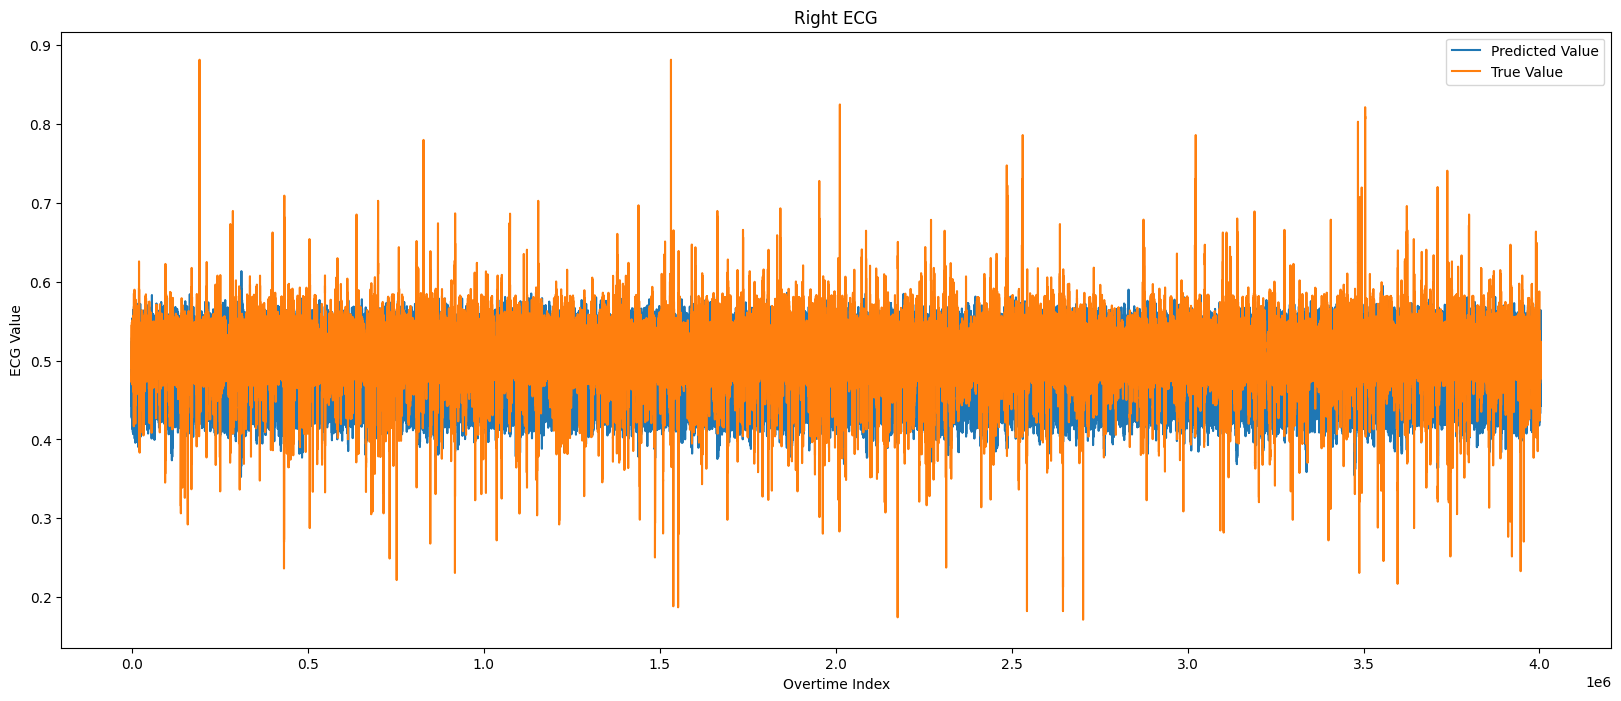

In [4]:

scatter = scatter_fn(y_pred_ARs[1].cpu(), y_true_ARs[1].cpu())
plt.title('Valence')
scatter.savefig('Valence.jpg')
scatter = plot_fn(y_pred_ECGs[0].cpu(), y_true_ECGs[0].cpu())
plt.title('Left ECG')
scatter.savefig('ecgl.jpg')
scatter = plot_fn(y_pred_ECGs[1].cpu(), y_true_ECGs[1].cpu())
plt.title('Right ECG')
scatter.savefig('ecgr.jpg')

In [7]:
y_pred_ECGs[0].shape[0] / 2560

1564.0

In [ ]:

scatter = plot_fn(y_pred_ECGs[0][:2560].cpu(), y_true_ECGs[0][:2560].cpu())
plt.title('Partial Left ECG')
scatter.savefig('ecgl2.jpg')
scatter = plot_fn(y_pred_ECGs[1][:2560].cpu(), y_true_ECGs[1][:2560].cpu())
plt.title('Partial Right ECG')
scatter.savefig('ecgr2.jpg')

In [ ]:


scatter = scatter_fn(y_pred_ARs[0].cpu(), y_true_ARs[0].cpu())
scatter = scatter_fn(y_pred_ARs[1].cpu(), y_true_ARs[1].cpu())
scatter = plot_fn(y_pred_ECGs[0].cpu(), y_true_ECGs[0].cpu())
scatter = plot_fn(y_pred_ECGs[1].cpu(), y_true_ECGs[1].cpu())